# Uber rides value estimation

<strong>Objectives:</strong> The main objective of this work is to collect data from Uber's Open API for a week requesting information about rides from a unique starting point and finalizing in a one point of all neighborhoods of Natal, capital of Rio Grande do Norte - Brazil.

<strong>Group components:</strong>
    <ul>
        <li>Marco Olimpio - marco.olimpio at gmail</li>
        <li>Rebecca Betwel - bekbetwel at gmail</li>
    </ul>
    
The Open Uber API (https://developer.uber.com/) has a limited number of requests per hour and his limited to 2000 requests. The citie of Natal has 36 neighborhoods so according to this we have to make 36 requests per set of neighborhoods, so we could do

$$ {2000}/{36} = 55.55$$

55 set of requests but we limited to only 1440 requests because we configured the data collector to execute this set of requests for every 90 seconds.

The data started to be collected from 29/11/2017 until 08/11/2017 in every 90 seconds. Generating about 34Mb of data and 235779 requests. With this configuration of the data collector if we we could be collect about:
$$ 10 days * 24 hours * 1440 requests = 345600 lines$$
or $235779/345600 = 68.22\%$ of data collecting efficiency. Unfortunatelly the computer collecting the data was my laptop.

How do we organized everything? We created a simple python collector that utilizes the Uber rides library. To install simply do

>```python
!pip install uber-rides
```

after that all you have to do is to create an user and configure a new application in Uber's development website. More information abour the Uber Rides could be found here: https://developer.uber.com/docs/riders/ride-requests/tutorials/api/python

Importing the Uber Rides
```python
from uber_rides.session import Session
from uber_rides.client import UberRidesClient
```

After this we collected some data to know how the API works and persisted the results in a comma separetad file (CSV). 
This CSV is loaded in this kernel and we start to play! :]
You could check the imagem below

<img src="uberDiagram.png"/>

In [1]:
%matplotlib inline
import os
import json
import pandas as pd

import sys
import numpy as np
from numpy import random

from shapely.geometry import Polygon
from shapely.geometry import Point
import folium
from branca.colormap import linear


import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import geojson file about natal neighborhood
natal_neigh = os.path.join('geojson', 'natal.geojson')

# load the data and use 'UTF-8'encoding
geo_json_natal = json.load(open(natal_neigh,encoding='UTF-8'))


In [3]:
neighborhood = []
# list all neighborhoods
for neigh in geo_json_natal['features']:
        neighborhood.append(neigh['properties']['name'])

In [4]:
# Create a map object
m2 = folium.Map(
    location=[-5.826592, -35.212558],
    zoom_start=12,
    tiles='cartodbpositron'
)

# Configure geojson layer
#folium.GeoJson(geo_json_natal).add_to(m2)

m2.geo_json(geo_path=geo_json_natal, data=state_data,
             columns=['State', 'Unemployment'],
             key_on='feature.id',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Unemployment Rate (%)')

In [47]:
m2

In [6]:
uberJsonRequests = pd.read_csv('../uberData/uberRidesRequests_01112017_2100.csv')

In [38]:
uberJsonRequests.head(3)

,id,timestamp,periodOfDay,neighborhood,start_latitude,start_longitude,finish_latitude,finish_longitude,currency_code,distance,duration,high_estimate,low_estimate,product_id,mean_estimate,region
0,1,2017-10-29 13:39:29.122787,afternoon,Pitimbu,-5.8323,-35.2054,-5.876271,-35.224500,BRL,4.44,660,16.0,12.0,65cb1829-9761-40f8-acc6-92d700fe2924,14.0,South
1,1,2017-10-29 13:39:29.122787,afternoon,Pitimbu,-5.8323,-35.2054,-5.876271,-35.224500,BRL,4.44,660,19.0,14.0,bf8f99ca-f5f2-40d4-8ffc-52f1e2b17138,16.5,South
2,1,2017-10-29 13:39:30.552931,afternoon,Planalto,-5.8323,-35.2054,-5.858102,-35.251586,BRL,6.50,1020,22.0,17.0,65cb1829-9761-40f8-acc6-92d700fe2924,19.5,West


In [46]:
uberJsonRequests['duration'].value_counts(sort=True)

900     15296
840     13832
660     13362
600     12606
720     11970
1080    11492
960     11404
1020    11258
780     10458
1140    10244
540      7596
1200     6726
360      6560
1500     5414
1560     5284
240      5000
1440     4706
1320     4292
1260     4194
1380     4102
1620     3918
1680     3846
420      3242
480      3166
1740     2342
300      1786
1800     1684
1920     1252
1860     1104
2100      978
2040      772
1980      406
2160      338
180       306
2340      142
2220      140
2400      126
2520      112
2280       70
60         60
2580       56
2700       38
120        18
2460       12
2640        4
Name: duration, dtype: int64

In [7]:
uberJsonRequests['mean_estimate'] = (uberJsonRequests['low_estimate']+uberJsonRequests['high_estimate'])/2

In [8]:
uberJsonRequests['timestamp'] = pd.to_datetime(uberJsonRequests['timestamp'])

In [9]:
uberJsonRequests.describe

<bound method NDFrame.describe of          id                  timestamp periodOfDay             neighborhood  \
0         1 2017-10-29 13:39:29.122787   afternoon                  Pitimbu   
1         1 2017-10-29 13:39:29.122787   afternoon                  Pitimbu   
2         1 2017-10-29 13:39:30.552931   afternoon                 Planalto   
3         1 2017-10-29 13:39:30.552931   afternoon                 Planalto   
4         1 2017-10-29 13:39:31.783796   afternoon              Ponta Negra   
5         1 2017-10-29 13:39:31.783796   afternoon              Ponta Negra   
6         1 2017-10-29 13:39:33.112852   afternoon                 Neópolis   
7         1 2017-10-29 13:39:33.112852   afternoon                 Neópolis   
8         1 2017-10-29 13:39:34.648221   afternoon              Capim Macio   
9         1 2017-10-29 13:39:34.648221   afternoon              Capim Macio   
10        1 2017-10-29 13:43:00.377291   afternoon                  Pitimbu   
11        1 2017-1

In [37]:
colormap = linear.GnBu.scale(uberJsonRequests['low_estimate'].mean(), uberJsonRequests['high_estimate'].mean())
colormap

In [27]:
#from branca.utilities import split_six
#threshold_scale = split_six(uberJsonRequests['high_estimate'])
#threshold_scale
threshold_scale = np.linspace(uberJsonRequests['low_estimate'].mean(),
                              uberJsonRequests['high_estimate'].mean(), 4, dtype=int).tolist()

In [28]:
threshold_scale

[19, 21, 22, 24]

In [12]:
neighborhood_dict = uberJsonRequests.set_index('neighborhood')['mean_estimate']

In [13]:
#Mean by neighborhood
minMeanByNeighborhood = uberJsonRequests.groupby('neighborhood')['low_estimate'].mean()
minMeanByNeighborhood

neighborhood
Alecrim                          16.418214
Areia Preta                      18.749107
Barro Vermelho                   14.425972
Bom Pastor                       14.838036
Candelária                        8.652872
Capim Macio                      12.688057
Cidade Alta                      18.221607
Cidade Nova                      17.998034
Cidade da Esperança              16.091137
Dix-Sept Rosado                  12.980714
Felipe Camarão                   18.684775
Guarapes                         28.878127
Igapó                            26.190935
Lagoa Azul                       36.011412
Lagoa Nova                        9.466250
Lagoa Seca                       12.128434
Mãe Luiza                        18.525357
Neópolis                         15.420171
Nordeste                         21.372143
Nossa Senhora da Apresentação    30.690935
Nossa Senhora de Nazaré          12.676607
Nova Descoberta                   7.302143
Pajuçara                         31.55708

<h2>Seting up administrative regions</h2>
According to wikipedia (https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Natal_(Rio_Grande_do_Norte)) Natal is divided in four administrative regions: South, East, West and North.
<ul>
    <li><strong>East</strong> - Alecrim</li>
    <li><strong>East</strong> - Areia Preta </li>
    <li><strong>East</strong> - Barro Vermelho  </li>
    <li><strong>East</strong> - Cidade Alta </li>
    <li><strong>East</strong> - Lagoa Seca  </li>
    <li><strong>East</strong> - Mãe Luíza   </li>
    <li><strong>East</strong> - Petrópolis  </li>
    <li><strong>East</strong> - Praia do Meio   </li>
    <li><strong>East</strong> - Ribeira </li>
    <li><strong>East</strong> - Rocas   </li>
    <li><strong>East</strong> - Santos Reis </li>
    <li><strong>East</strong> - Tirol   </li>
    <li><strong>North</strong> - Igapó   </li>
    <li><strong>North</strong> - Lagoa Azul  </li>
    <li><strong>North</strong> - Nossa Senhora da Apresentação   </li>
    <li><strong>North</strong> - Pajuçara    </li>
    <li><strong>North</strong> - Potengi </li>
    <li><strong>North</strong> - Redinha </li>
    <li><strong>North</strong> - Salinas </li>
    <li><strong>South</strong> - Candelária  </li>
    <li><strong>South</strong> - Capim Macio </li>
    <li><strong>South</strong> - Lagoa Nova  </li>
    <li><strong>South</strong> - Neópolis    </li>
    <li><strong>South</strong> - Nova Descoberta </li>
    <li><strong>South</strong> - Pitimbu </li>
    <li><strong>South</strong> - Ponta Negra </li>
    <li><strong>West</strong> - Bom Pastor  </li>
    <li><strong>West</strong> - Cidade da Esperança </li>
    <li><strong>West</strong> - Cidade Nova </li>
    <li><strong>West</strong> - Dix-Sept Rosado </li>
    <li><strong>West</strong> - Felipe Camarão  </li>
    <li><strong>West</strong> - Guarapes    </li>
    <li><strong>West</strong> - Nordeste    </li>
    <li><strong>West</strong> - Nossa Senhora de Nazaré </li>
    <li><strong>West</strong> - Planalto    </li>
    <li><strong>West</strong> - Quintas </li>
</ul>

In [14]:
def label_region (row):
   if row['neighborhood'] == 'Alecrim' or row['neighborhood'] == 'Areia Preta'  or row['neighborhood'] == 'Barro Vermelho' or row['neighborhood'] == 'Cidade Alta' or row['neighborhood'] == 'Lagoa Seca'  or row['neighborhood'] == 'Mãe Luiza'  or row['neighborhood'] == 'Petrópolis' or row['neighborhood'] == 'Praia do Meio' or row['neighborhood'] == 'Ribeira' or row['neighborhood'] == 'Rocas' or row['neighborhood'] == 'Santos Reis' or row['neighborhood'] == 'Tirol':
      return 'East'
   if row['neighborhood'] =='Igapó' or row['neighborhood']=='Lagoa Azul' or row['neighborhood']=='Nossa Senhora da Apresentação' or row['neighborhood']=='Pajuçara' or row['neighborhood']=='Potengi' or row['neighborhood']=='Redinha' or row['neighborhood']=='Salinas':
      return 'North'
   if row['neighborhood'] =='Candelária' or row['neighborhood']=='Capim Macio' or row['neighborhood']=='Lagoa Nova' or row['neighborhood']=='Neópolis' or row['neighborhood']=='Nova Descoberta' or row['neighborhood']=='Pitimbu' or row['neighborhood']=='Ponta Negra':
      return 'South'
   if row['neighborhood'] =='Bom Pastor' or row['neighborhood']=='Cidade da Esperança' or row['neighborhood']=='Cidade Nova' or row['neighborhood']=='Dix-Sept Rosado' or row['neighborhood']=='Felipe Camarão' or row['neighborhood']=='Guarapes' or row['neighborhood']=='Nordeste' or row['neighborhood']=='Nossa Senhora de Nazaré' or row['neighborhood']=='Planalto' or row['neighborhood']=='Quintas':
      return 'West'
   return ''

In [15]:
uberJsonRequests['region'] = uberJsonRequests.apply(label_region, axis=1)

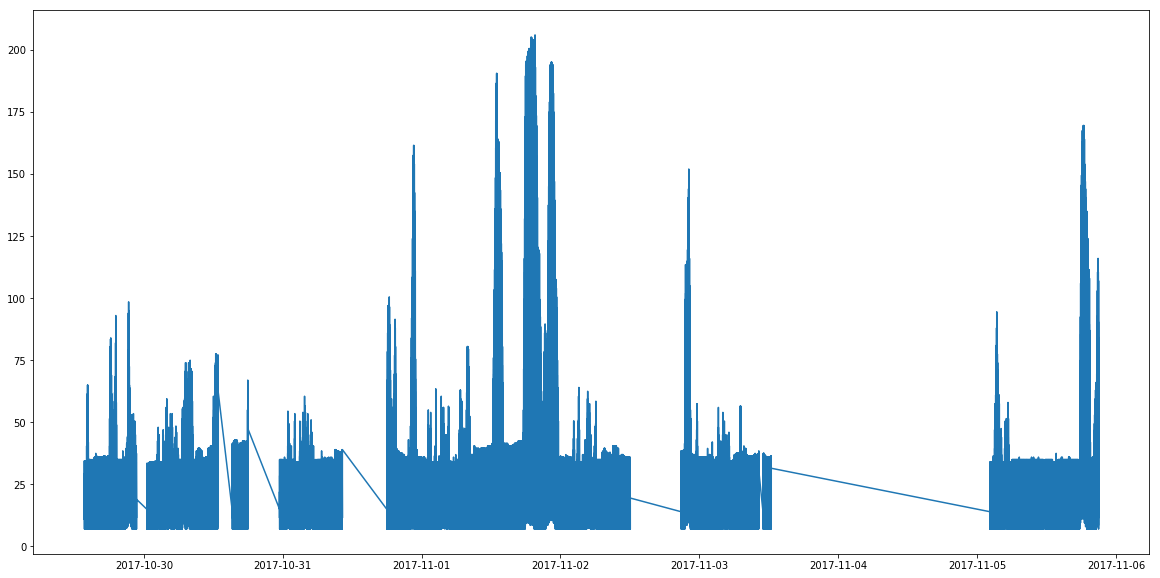

In [16]:
plt.figure(figsize=(20,10))
plt.plot(uberJsonRequests['timestamp'],uberJsonRequests['mean_estimate'])
#uberJsonRequests['mean_estimate'].plot()
#for title, group in uberJsonRequests.groupby('neighborhood'):
#    group.plot(x='timestamp', y='mean_estimate', title=title)

In [17]:
plotUberEast = uberJsonRequests[uberJsonRequests['region']=='East'][['neighborhood', 'mean_estimate']]
plotUberNorth = uberJsonRequests[uberJsonRequests['region']=='North'][['neighborhood', 'mean_estimate']]
plotUberSouth = uberJsonRequests[uberJsonRequests['region']=='South'][['neighborhood', 'mean_estimate']]
plotUberWest = uberJsonRequests[uberJsonRequests['region']=='West'][['neighborhood', 'mean_estimate']]

## East distribution

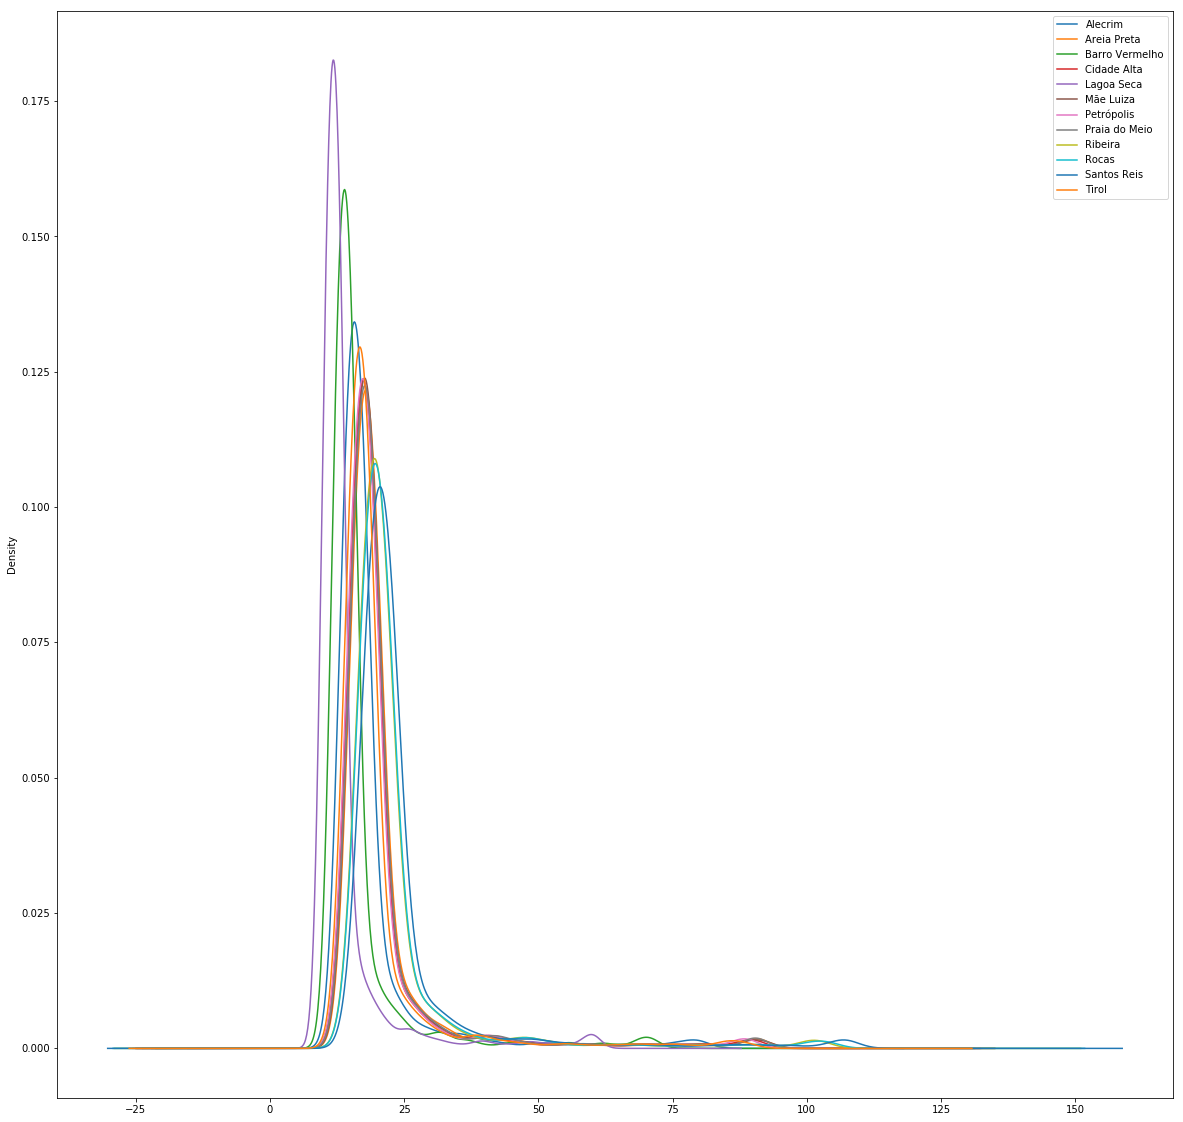

In [18]:
fig, ax = plt.subplots(figsize=(20,20))
for label, df in plotUberEast.groupby('neighborhood'):
    df.mean_estimate.plot(kind="kde", ax=ax, label=label)
plt.legend()

## South

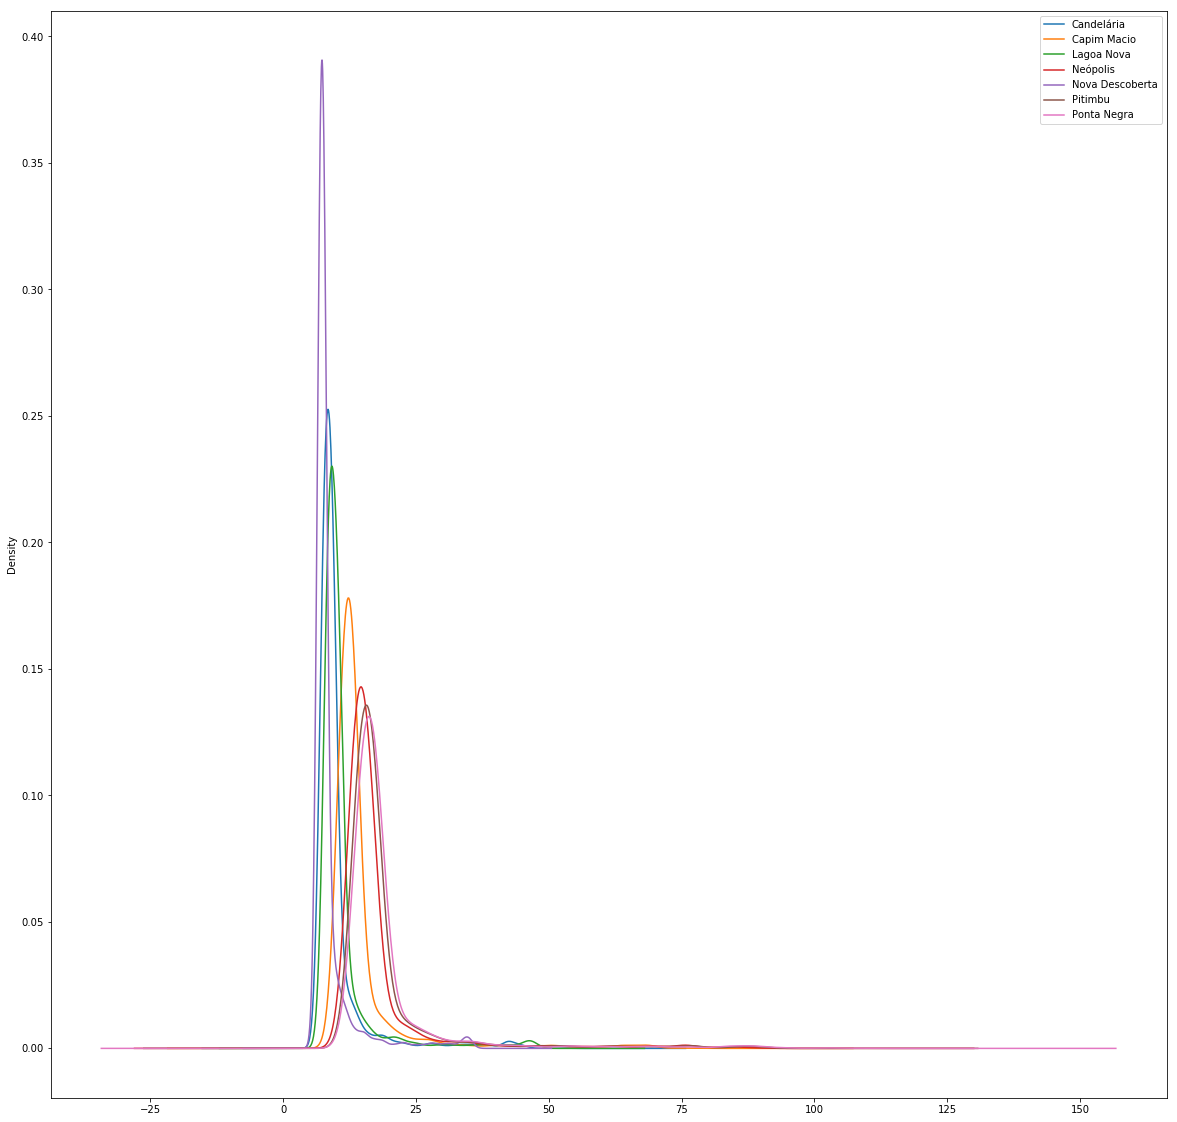

In [19]:
fig, ax = plt.subplots(figsize=(20,20))
for label, df in plotUberSouth.groupby('neighborhood'):
    df.mean_estimate.plot(kind="kde", ax=ax, label=label)
plt.legend()

## West

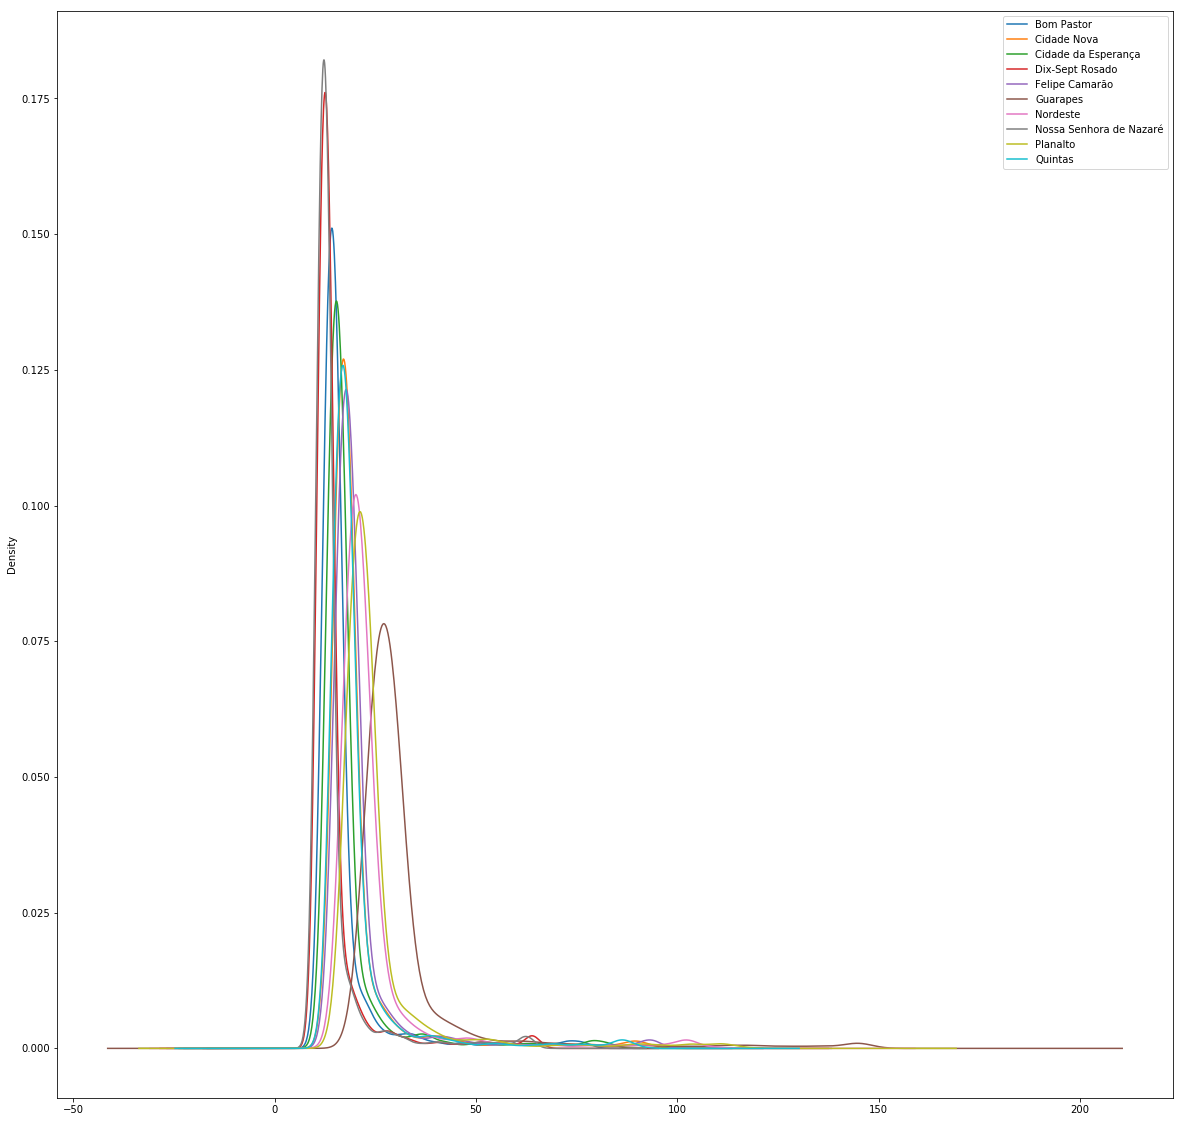

In [20]:
fig, ax = plt.subplots(figsize=(20,20))
for label, df in plotUberWest.groupby('neighborhood'):
    df.mean_estimate.plot(kind="kde", ax=ax, label=label)
plt.legend()

## North

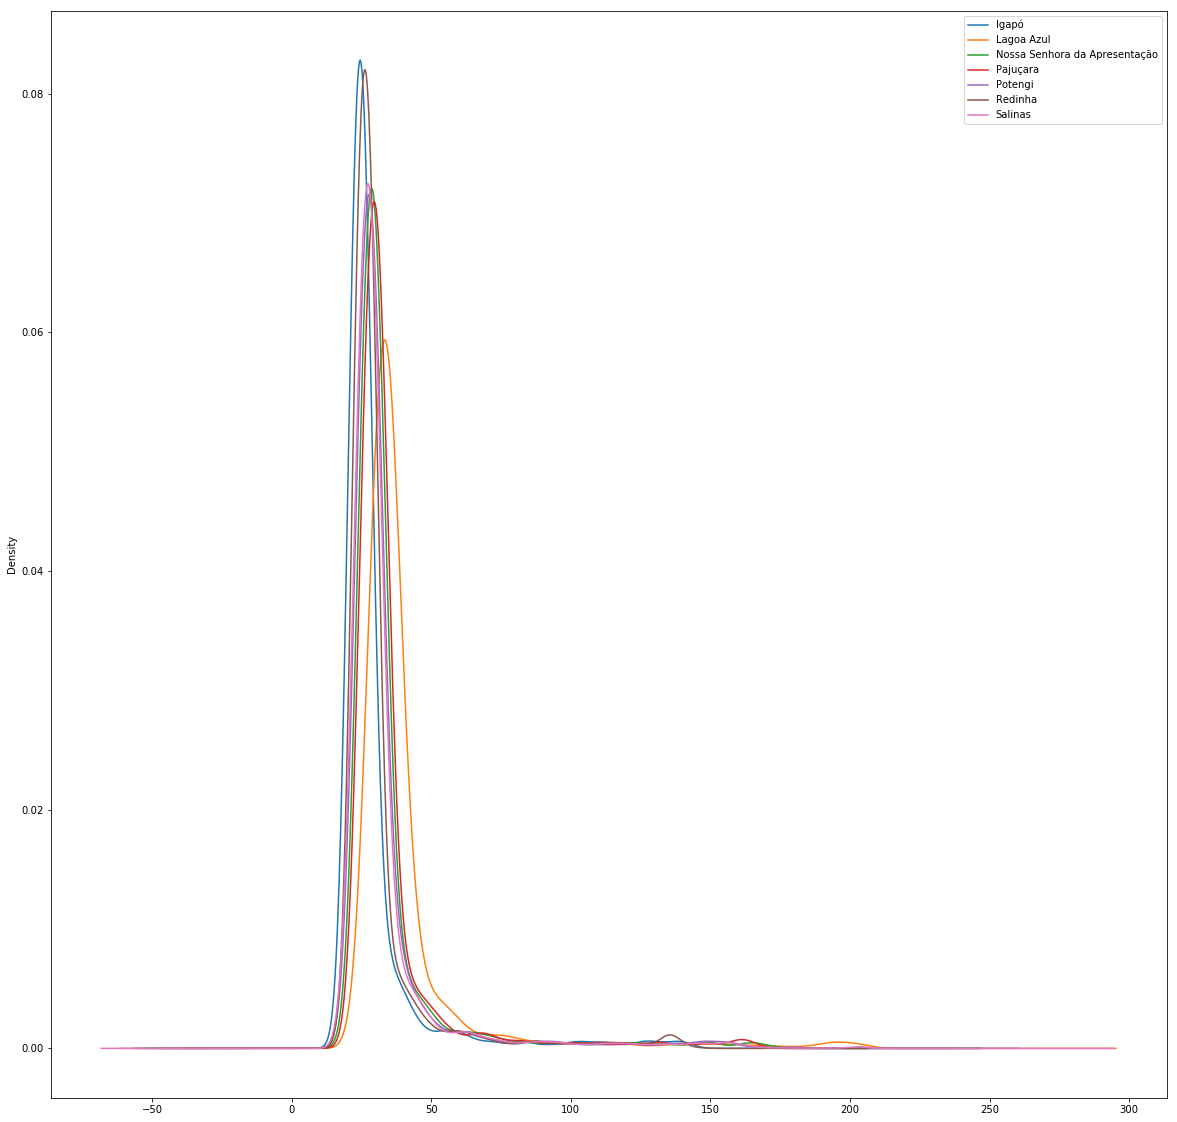

In [21]:
fig, ax = plt.subplots(figsize=(20,20))
for label, df in plotUberNorth.groupby('neighborhood'):
    df.mean_estimate.plot(kind="kde", ax=ax, label=label)
plt.legend()

In [162]:
uberJsonRequests.describe

<bound method NDFrame.describe of          id                  timestamp periodOfDay             neighborhood  \
0         1 2017-10-29 13:39:29.122787   afternoon                  Pitimbu   
1         1 2017-10-29 13:39:29.122787   afternoon                  Pitimbu   
2         1 2017-10-29 13:39:30.552931   afternoon                 Planalto   
3         1 2017-10-29 13:39:30.552931   afternoon                 Planalto   
4         1 2017-10-29 13:39:31.783796   afternoon              Ponta Negra   
5         1 2017-10-29 13:39:31.783796   afternoon              Ponta Negra   
6         1 2017-10-29 13:39:33.112852   afternoon                 Neópolis   
7         1 2017-10-29 13:39:33.112852   afternoon                 Neópolis   
8         1 2017-10-29 13:39:34.648221   afternoon              Capim Macio   
9         1 2017-10-29 13:39:34.648221   afternoon              Capim Macio   
10        1 2017-10-29 13:43:00.377291   afternoon                  Pitimbu   
11        1 2017-1

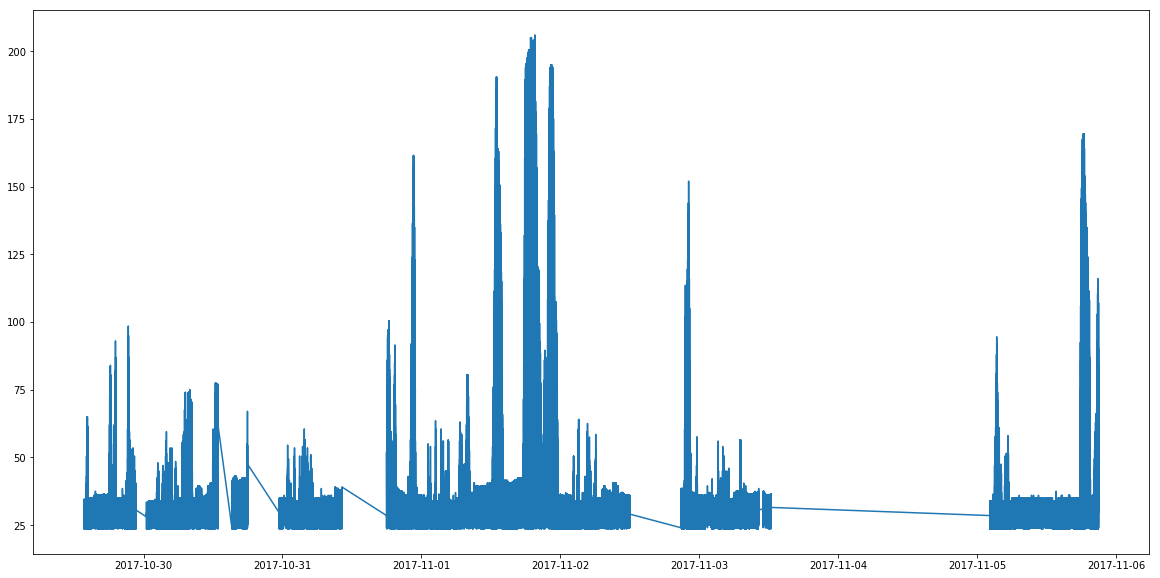

In [22]:
plt.figure(figsize=(20,10))
plt.plot(uberJsonRequests[uberJsonRequests['mean_estimate']>23]['timestamp'],uberJsonRequests[uberJsonRequests['mean_estimate']>23]['mean_estimate'])

In [23]:
maxMeanByNeighborhood = uberJsonRequests.groupby('neighborhood')['high_estimate'].mean()
maxMeanByNeighborhood

neighborhood
Alecrim                          21.177857
Areia Preta                      23.977857
Barro Vermelho                   18.666429
Bom Pastor                       19.228393
Candelária                       11.591687
Capim Macio                      16.732264
Cidade Alta                      23.384464
Cidade Nova                      23.109185
Cidade da Esperança              20.746426
Dix-Sept Rosado                  16.956429
Felipe Camarão                   23.978914
Guarapes                         36.411187
Igapó                            33.120807
Lagoa Azul                       45.140514
Lagoa Nova                       12.775357
Lagoa Seca                       15.975205
Mãe Luiza                        23.746786
Neópolis                         19.888275
Nordeste                         27.215000
Nossa Senhora da Apresentação    38.594575
Nossa Senhora de Nazaré          16.518571
Nova Descoberta                   9.996964
Pajuçara                         39.67606

In [72]:
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')

In [83]:
boxplotuber = uberJsonRequests.groupby('neighborhood')[['low_estimate','high_estimate']]

/Users/marco/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


neighborhood
Alecrim                          Axes(0.125,0.125;0.775x0.755)
Areia Preta                      Axes(0.125,0.125;0.775x0.755)
Barro Vermelho                   Axes(0.125,0.125;0.775x0.755)
Bom Pastor                       Axes(0.125,0.125;0.775x0.755)
Candelária                       Axes(0.125,0.125;0.775x0.755)
Capim Macio                      Axes(0.125,0.125;0.775x0.755)
Cidade Alta                      Axes(0.125,0.125;0.775x0.755)
Cidade Nova                      Axes(0.125,0.125;0.775x0.755)
Cidade da Esperança              Axes(0.125,0.125;0.775x0.755)
Dix-Sept Rosado                  Axes(0.125,0.125;0.775x0.755)
Felipe Camarão                   Axes(0.125,0.125;0.775x0.755)
Guarapes                         Axes(0.125,0.125;0.775x0.755)
Igapó                            Axes(0.125,0.125;0.775x0.755)
Lagoa Azul                       Axes(0.125,0.125;0.775x0.755)
Lagoa Nova                       Axes(0.125,0.125;0.775x0.755)
Lagoa Seca                       Axes(0.12

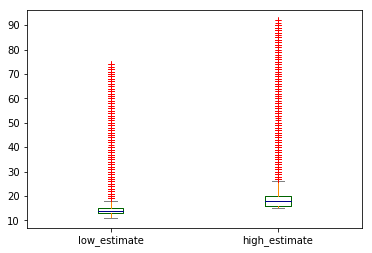

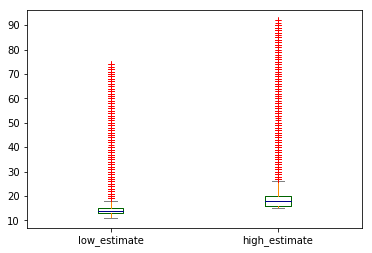

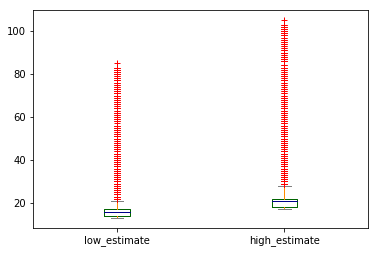

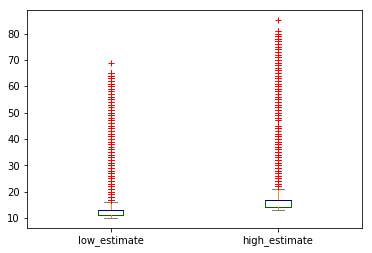

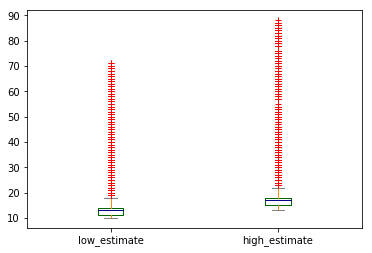

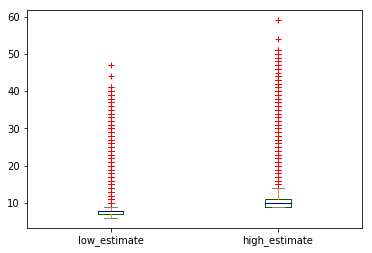

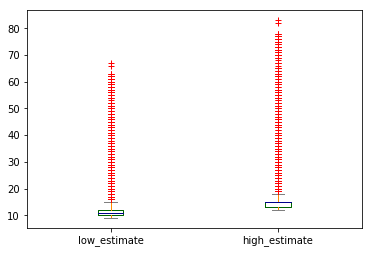

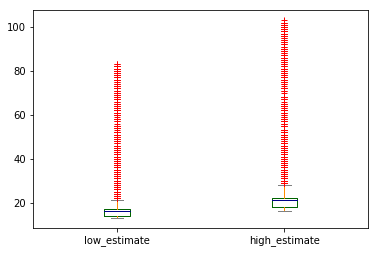

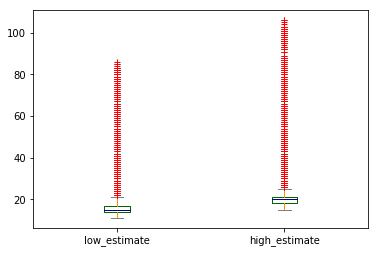

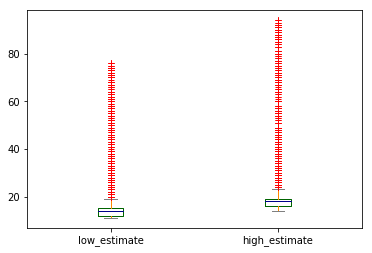

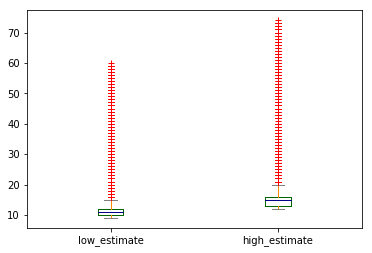

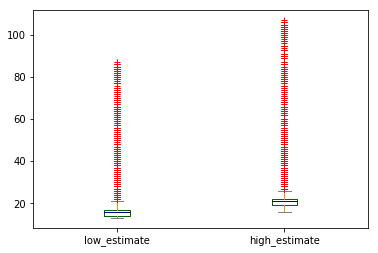

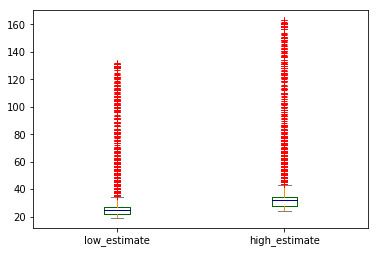

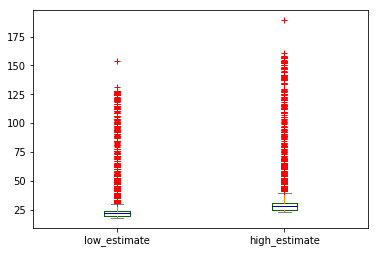

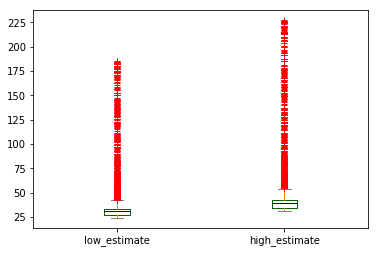

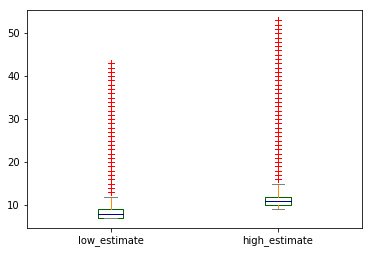

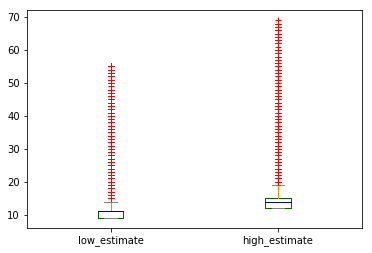

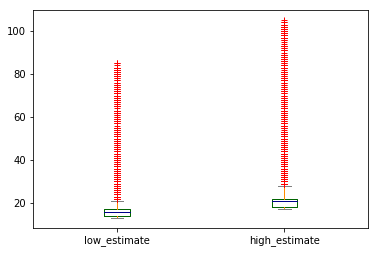

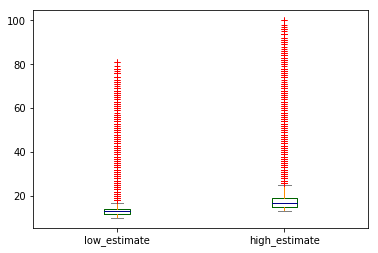

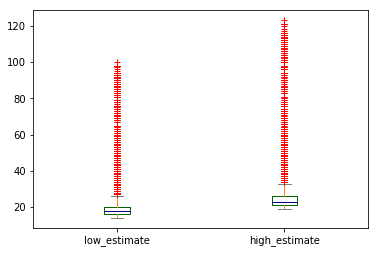

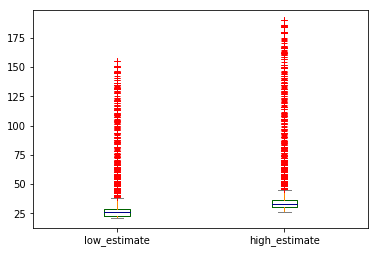

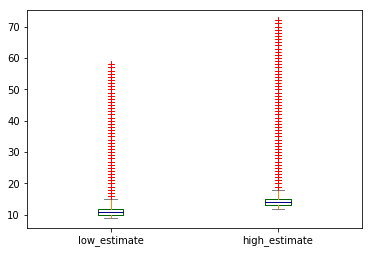

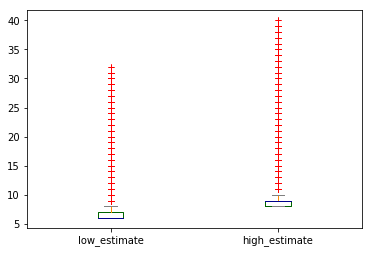

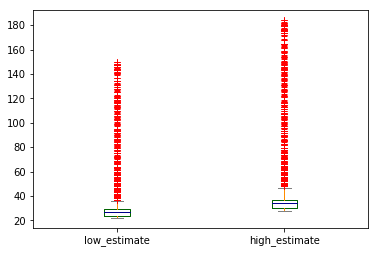

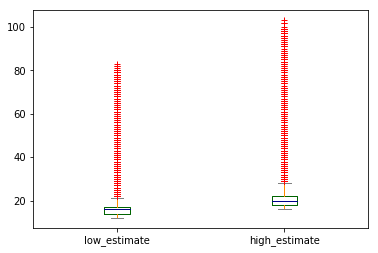

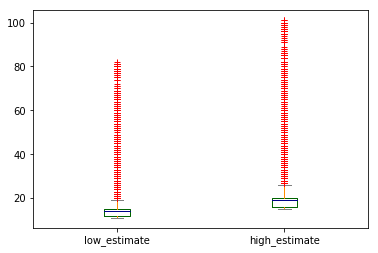

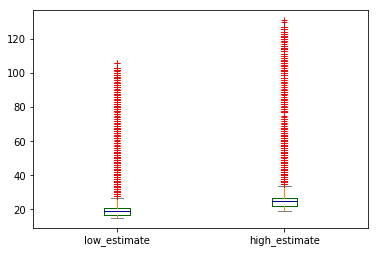

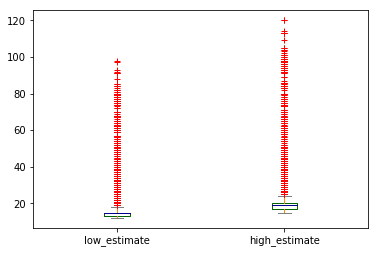

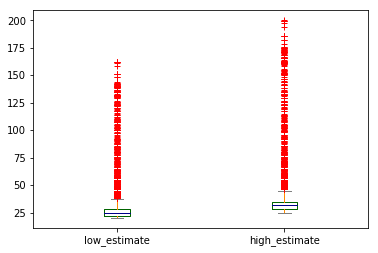

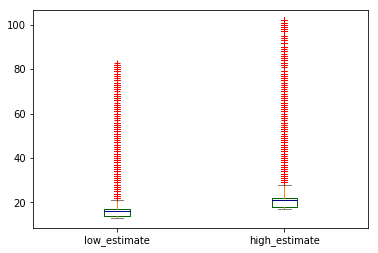

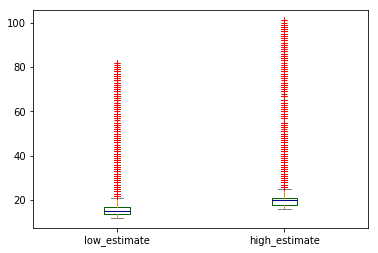

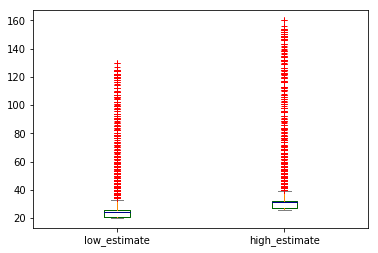

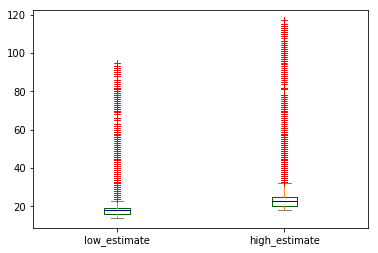

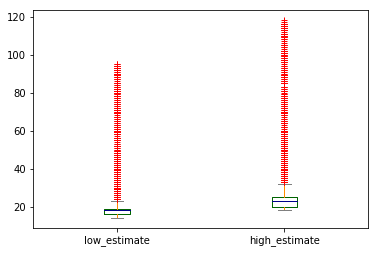

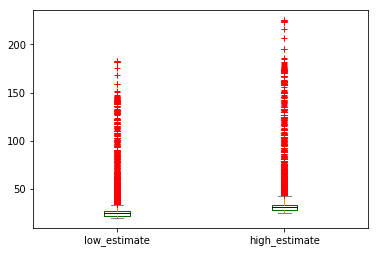

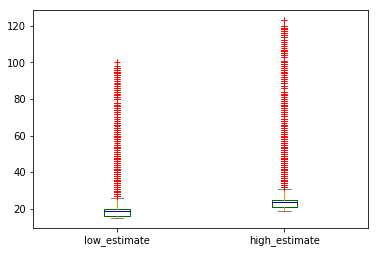

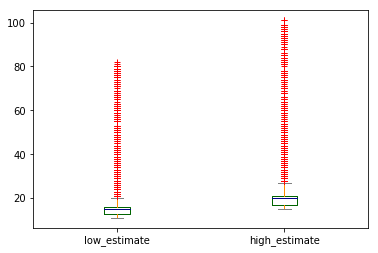

In [84]:
boxplotuber.plot.box(color=color, sym='r+')

In [29]:
# Configure geojson layer
#folium.GeoJson(
#    geo_json_natal,
#    name='Uber rides values estimation of Natal - Data collected from 10/29/2017 to 11/05/2017',
#    style_function=lambda feature: {
#        data=uberJsonRequests,
#        columns=['neighborhood', 'high_estimate'],
#        'fillColor': 'RdGy',
#        'color': 'black',
#        'weight': 1,
#        'dashArray': '5, 5',
#        'fillOpacity': 0.9,
#    }
#).add_to(m)
#m

m2.choropleth(
    geo_data=geo_json_natal,
    data=uberJsonRequests,
    columns=['neighborhood', 'mean_estimate'],
    key_on='feature.properties.description',
    fill_color='GnBu',
    legend_name='Uber rides values estimation of Natal - Data collected from 10/29/2017 to 11/05/2017',
    highlight=True,
    threshold_scale = threshold_scale
)

In [30]:
m2

In [32]:
folium.Marker([-5.796158, -35.216566], popup='Alecrim, Valor médio: 21.177857').add_to(m2)
folium.Marker([-5.789477, -35.188454], popup='Areia Preta, Valor médio: 23.977857').add_to(m2)
folium.Marker([-5.800741, -35.211056], popup='Barro Vermelho, Valor médio: 18.666429').add_to(m2)
folium.Marker([-5.813764, -35.240721], popup='Bom Pastor, Valor médio: 19.228393').add_to(m2)
folium.Marker([-5.841737, -35.210463], popup='Candelária, Valor médio: 11.591687').add_to(m2)
folium.Marker([-5.862753, -35.195597], popup='Capim Macio, Valor médio: 16.732264').add_to(m2)
folium.Marker([-5.785291, -35.206464], popup='Cidade Alta, Valor médio: 23.384464').add_to(m2)
folium.Marker([-5.825376, -35.242751], popup='Cidade da Esperança, Valor médio: 23.109185').add_to(m2)
folium.Marker([-5.834856, -35.242523], popup='Cidade Nova, Valor médio: 20.746426').add_to(m2)
folium.Marker([-5.812036, -35.223915], popup='Dix-Sept Rosado, Valor médio: 16.956429').add_to(m2)
folium.Marker([-5.824374, -35.250070], popup='Felipe Camarão, Valor médio: 23.978914').add_to(m2)
folium.Marker([-5.841580, -35.274691], popup='Guarapes, Valor médio: 36.411187').add_to(m2)
folium.Marker([-5.769009, -35.254755], popup='Igapó, Valor médio: 33.120807').add_to(m2)
folium.Marker([-5.734177, -35.253802], popup='Lagoa Azul, Valor médio: 45.140514').add_to(m2)
folium.Marker([-5.819743, -35.212920], popup='Lagoa Nova, Valor médio: 12.775357').add_to(m2)
folium.Marker([-5.809191, -35.209374], popup='Lagoa Seca, Valor médio: 15.975205').add_to(m2)
folium.Marker([-5.794771, -35.188619], popup='Mãe Luiza, Valor médio: 23.746786').add_to(m2)
folium.Marker([-5.870513, -35.208176], popup='Neópolis, Valor médio: 19.888275').add_to(m2)
folium.Marker([-5.796215, -35.245141], popup='Nordeste, Valor médio: 27.215000').add_to(m2)
folium.Marker([-5.763654, -35.282543], popup='Nossa Senhora da Apresentação, Valor médio: 38.594575').add_to(m2)
folium.Marker([-5.815939, -35.229249], popup='Nossa Senhora de Nazaré, Valor médio: 16.518571').add_to(m2)
folium.Marker([-5.824830, -35.200026], popup='Nova Descoberta, Valor médio: 9.996964').add_to(m2)
folium.Marker([-5.751781, -35.234665], popup='Pajuçara, Valor médio: 39.676061').add_to(m2)
folium.Marker([-5.782001, -35.195196], popup='Petrópolis, Valor médio: 23.243929').add_to(m2)
folium.Marker([-5.876271, -35.224500], popup='Pitimbu, Valor médio: 21.161262').add_to(m2)
folium.Marker([-5.858102, -35.251586], popup='Planalto, Valor médio: 28.573770').add_to(m2)
folium.Marker([-5.877522, -35.176073], popup='Ponta Negra, Valor médio: 21.856557').add_to(m2)
folium.Marker([-5.758634, -35.247010], popup='Potengi, Valor médio: 37.519636').add_to(m2)
folium.Marker([-5.779198, -35.197163], popup='Praia do Meio, Valor médio: 23.750624').add_to(m2)
folium.Marker([-5.797290, -35.226006], popup='Quintas, Valor médio: 22.788750').add_to(m2)
folium.Marker([-5.742772, -35.205806], popup='Redinha, Valor médio: 35.059579').add_to(m2)
folium.Marker([-5.774943, -35.205578], popup='Ribeira, Valor médio: 26.279643').add_to(m2)
folium.Marker([-5.771832, -35.203091], popup='Rocas, Valor médio: 26.428826').add_to(m2)
folium.Marker([-5.763117, -35.247973], popup='Salinas, Valor médio: 37.037460').add_to(m2)
folium.Marker([-5.763226, -35.196786], popup='Santos Reis, Valor médio: 27.564395').add_to(m2)
folium.Marker([-5.791699, -35.197358], popup='Tirol, Valor médio: 22.539286').add_to(m2)

In [33]:
m2